# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.25 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (26312/26312), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [464, shufflenet_v2_x1_0, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [116, 5]]           # 1: P3 raw (stride 8)
  - [0, 1, Index, [232, 6]]           # 2: P4 raw (stride 16)
  - [0, 1, Index, [464, 7]]         # 3: P5 raw (stride 32)

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [1, 1, Conv, [64, 1, 1]]         # 4: P3 → 64
  - [2, 1, Conv, [128, 1, 1]]        # 5: P4 → 128
  - [3, 1, Conv, [256, 1, 1]]        # 6: P5 → 256

  # FPN: P5 → P4
  - [6, 1, nn.Upsample, [None, 2, "nearest"]]  # 7
  - [[7, 5], 1, Concat, [1]]                   # 8
  - [-1, 1, C3k2, [128, False]]                # 9 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 4], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [64, False]]                 # 12 (256 → 64)

  # PAN: P3 → P4
  - [12, 1, Conv, [64, 3, 2]]                  # 13
  - [[13, 9], 1, Concat, [1]]                  # 14
  - [-1, 1, C3k2, [128, False]]                # 15

  # PAN: P4 → P5
  - [15, 1, Conv, [128, 3, 2]]                 # 16
  - [[16, 6], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [256, True]]                 # 18

  # Final detection layers
  - [[12, 15, 18], 1, Detect, [nc]]            # 19
  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 116, 80, 80])
# 6 torch.Size([1, 232, 40, 40])
# 7 torch.Size([1, 464, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 155MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 4.11MB/s]
E0000 00:00:1745410148.007158      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745410148.059276      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    776420  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x1_0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  4                   1  1      7552  ultralytics.nn.modules.conv.Conv             [116, 64, 1, 1]               
  5                   2  1     29952  ultralytics.nn.modules.conv.Conv             [232, 128, 1, 1]              
  6                   3  1    119296  ultralytics.nn.modules.conv.Conv             [464, 25

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:03<00:00, 143.35it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 148.26it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 106 weight(decay=0.0005), 105 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.65G      3.805       91.5      3.257         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300       3.1G      4.515      18.15      3.037         52        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      3.11G      3.997      5.004      1.957         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

                   all        200       1017    0.00218      0.101    0.00673    0.00136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      3.11G      3.531      3.488      1.444         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


                   all        200       1017      0.225      0.179     0.0806      0.015

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      3.11G      3.305      2.947      1.344         50        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        200       1017      0.268      0.244       0.12     0.0252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      3.11G      3.222      2.669       1.27         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.289      0.287      0.157     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      3.11G      3.121      2.471      1.263         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        200       1017      0.333      0.314       0.18     0.0428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      3.11G      3.034      2.317      1.211         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200       1017      0.359      0.337      0.227     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      3.11G      3.036      2.231      1.231         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


                   all        200       1017      0.357      0.295      0.187     0.0482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      3.11G      2.953      2.075      1.209         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200       1017      0.366      0.353      0.234     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      3.11G      2.957      2.063      1.168         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


                   all        200       1017      0.401       0.36      0.247     0.0613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      3.11G      2.946      2.069      1.193         18        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


                   all        200       1017      0.435       0.36      0.273     0.0664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      3.11G      2.915      1.963      1.193         16        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200       1017      0.513      0.364      0.282     0.0702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      3.11G      2.817      1.855      1.123         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

                   all        200       1017      0.434      0.324      0.262     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      3.11G      2.799      1.776      1.129         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200       1017      0.454      0.387      0.315     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      3.11G      2.787      1.732      1.132         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.502      0.384      0.312      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      3.11G      2.736      1.645      1.126         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.505      0.386      0.342     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      3.11G      2.805      1.643      1.177         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017      0.484      0.397      0.346      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      3.11G      2.684      1.577      1.136         49        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


                   all        200       1017      0.488      0.372      0.321     0.0935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      3.11G      2.662      1.559      1.108         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017      0.507      0.412      0.352        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      3.11G      2.664      1.531      1.164         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.537       0.37      0.325      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      3.11G      2.648      1.469      1.126         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017       0.47      0.344      0.308     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      3.11G      2.646      1.444      1.081         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.542      0.378      0.331     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      3.11G      2.636       1.42      1.086         29        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.494      0.399      0.341      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      3.11G      2.611      1.425      1.095         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.552      0.431      0.378       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      3.11G      2.542      1.373      1.116         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.578      0.405      0.353      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      3.11G      2.661      1.407      1.084         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.539       0.41      0.359      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      3.11G      2.577      1.371      1.097         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200       1017      0.482      0.412      0.329     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      3.11G      2.652       1.36      1.086         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.525      0.441      0.383      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      3.11G      2.545      1.315      1.063         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.531      0.438      0.386      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      3.11G      2.504      1.303      1.125         24        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017      0.492      0.418      0.371      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      3.11G      2.498       1.26      1.079         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.526      0.415       0.37      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      3.11G      2.576      1.322      1.108         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all        200       1017      0.554      0.373      0.354      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      3.11G      2.467      1.249      1.052         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200       1017      0.565      0.401      0.391      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      3.11G      2.494      1.246      1.071         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017      0.586      0.393      0.406       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      3.11G      2.575      1.263       1.05         32        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


                   all        200       1017      0.557      0.415      0.385       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      3.11G       2.52      1.297      1.067         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.538      0.387      0.384      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      3.11G      2.523      1.251      1.073         41        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200       1017      0.525      0.411      0.388      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      3.11G      2.472      1.235      1.043         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


                   all        200       1017      0.558      0.412      0.384      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      3.11G      2.451      1.228      1.086         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.527      0.434      0.407      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      3.11G      2.462      1.187      1.064         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200       1017       0.52      0.438      0.383      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      3.11G      2.402      1.158      1.085         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200       1017      0.571      0.443      0.434      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      3.11G      2.447      1.212      1.026         22        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.543      0.394      0.379      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      3.11G       2.44      1.177      1.092         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200       1017      0.556      0.453      0.427      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      3.11G       2.43      1.192      1.028         41        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.541      0.403      0.395      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      3.11G      2.395      1.161      1.034         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200       1017      0.555      0.426      0.395      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      3.11G       2.39      1.127       1.04         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.616      0.474      0.469      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      3.11G      2.445      1.156      1.015         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.537       0.39      0.381      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      3.11G      2.385      1.163      1.046         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        200       1017      0.548      0.414      0.401       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      3.11G       2.47       1.16      1.048         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all        200       1017      0.592      0.447      0.447      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      3.11G      2.359      1.106      1.028         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.562      0.419      0.428      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      3.11G      2.366      1.118      1.029         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200       1017      0.595      0.425      0.422      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      3.11G      2.384      1.123      1.019         57        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.587      0.452      0.444      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      3.11G      2.332      1.107       1.06         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        200       1017      0.589      0.453      0.441      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      3.11G      2.317      1.119      1.081         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        200       1017      0.603      0.445      0.445       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      3.11G      2.388      1.122      1.026         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.585      0.448      0.428       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      3.11G      2.303      1.114      1.005         11        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200       1017      0.576      0.461      0.434      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      3.11G      2.372      1.104      1.036         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200       1017      0.597       0.47      0.444       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      3.11G      2.289      1.089      1.037         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.548      0.434      0.428       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      3.11G      2.291       1.07      1.035         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200       1017      0.591      0.454      0.455      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      3.11G      2.308      1.079      1.001         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.562      0.463      0.444       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      3.11G      2.296      1.092      1.046         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.611      0.455      0.467      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      3.11G      2.345      1.086      1.011         45        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017        0.6      0.453       0.46      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      3.11G      2.263       1.05      1.021         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200       1017      0.592      0.453      0.434      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      3.11G      2.214       1.03      1.012         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200       1017      0.627      0.424      0.433      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      3.11G      2.253      1.035     0.9931         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        200       1017      0.576      0.456      0.449      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      3.11G      2.321      1.072      1.015         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200       1017      0.579      0.447      0.452      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      3.11G      2.263      1.038      1.022         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200       1017      0.627      0.465      0.463      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      3.11G      2.274      1.073      1.012         13        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        200       1017      0.545      0.401      0.406       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      3.11G      2.296      1.085     0.9914         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        200       1017      0.624      0.464      0.479      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      3.11G      2.258      1.057      1.013         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017       0.64      0.474      0.466      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      3.11G      2.224     0.9993      1.022         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017      0.573      0.436      0.442      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      3.11G      2.315      1.045      1.023         46        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200       1017      0.556      0.444      0.439       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      3.11G      2.193      1.014      1.026         44        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200       1017       0.64      0.451      0.475      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      3.11G      2.196     0.9816     0.9972         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        200       1017      0.587      0.446       0.44      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      3.11G      2.249      1.033      1.022         45        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        200       1017      0.584       0.46      0.438      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      3.11G      2.205      1.002      0.997         19        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.628      0.451      0.459      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      3.11G      2.187      1.002      1.051         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all        200       1017      0.553      0.447      0.444      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      3.11G      2.222      1.009      1.021         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200       1017      0.623      0.478      0.491      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      3.11G      2.243      0.999     0.9851         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.641       0.47      0.492      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      3.11G      2.141     0.9754      1.012         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.634      0.454       0.48       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      3.11G      2.159     0.9804     0.9925         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.649      0.488      0.508      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      3.11G      2.181      1.003      0.983         40        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.674      0.492      0.511       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      3.11G      2.239      1.012       1.01         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        200       1017       0.62      0.454      0.481      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      3.11G      2.221      1.038      1.009         56        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        200       1017      0.621      0.483      0.486      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      3.11G      2.191     0.9947     0.9959         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.579       0.47      0.455      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      3.11G      2.174     0.9763     0.9977         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200       1017      0.576      0.476      0.479      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      3.11G      2.131     0.9873      1.013         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.573      0.483      0.464      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      3.11G      2.159      1.002      1.011         60        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.623      0.467      0.477      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      3.11G      2.106      0.944     0.9786         53        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200       1017      0.622       0.46       0.48      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      3.11G      2.207     0.9807     0.9692         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.635      0.429      0.457      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      3.11G      2.105     0.9423      0.979         41        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        200       1017      0.656      0.479      0.503      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      3.11G      2.103     0.9433     0.9464         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.632      0.491      0.494      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      3.11G      2.091     0.9206     0.9749         42        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.649      0.464      0.495      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      3.11G       2.13     0.9601     0.9761         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


                   all        200       1017      0.639       0.48      0.487      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      3.11G      2.098      0.959     0.9716         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.638      0.479      0.491      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      3.11G      2.032     0.9187     0.9747         17        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        200       1017      0.622      0.464      0.451      0.145


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 82, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

97 epochs completed in 0.428 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 221 layers, 2,149,735 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


                   all        200       1017      0.648      0.487      0.507      0.171


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dc5d4787210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 7 humans, 49.7ms
Speed: 2.3ms preprocess, 49.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


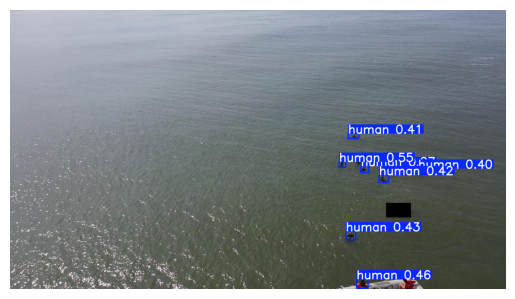

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 221 layers, 2,149,735 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:09<00:00, 21.75it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


                   all        200       1072      0.662      0.546      0.549      0.192


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 2.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dc5d16197d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)